In [30]:
"""
NLP from scratch: Classifying names with a character-level RNN and LSTM
"""


from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random

print('Done')

Done


In [31]:
"""
Step 1. Preparing the data
"""

def findFiles(path): 
    return glob.glob(path)

path = '/home/song/Downloads/Project3_code_and_data/data/names/'
print(findFiles(path+'*.txt'))

['/home/song/Downloads/Project3_code_and_data/data/names/Chinese.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Portuguese.txt', '/home/song/Downloads/Project3_code_and_data/data/names/German.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Czech.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Korean.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Dutch.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Arabic.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Greek.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Japanese.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Irish.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Russian.txt', '/home/song/Downloads/Project3_code_and_data/data/names/French.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Polish.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Spanish.txt', '/home/song/Downloads/Projec

In [32]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

#  Turning a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

#  Building the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

#  Reading a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(path+'*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)

#  Now we have category_lines, a dictionary mapping each category (language) to a 
#list of lines (names). We also kept track of all_categories (just a list of 
#languages) and n_categories for later reference.


Slusarski
18


In [4]:
"""
Step 2. Turning names into tensors
"""
#  Now that we have all names organized, we need to turn them into Tensors to make 
#any use of them. To represent a single letter, we use a ``one-hot vector'' of size 
#<1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the 
#current letter, e.g. "b" = <0 1 0 0 0 ...>
#  To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>
#The extra 1 dimension is because PyTorch assumes everything is in batches -- we're
#just using a batch size of 1 here.
import torch

# Finding letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turning a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turning a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Task1


It involves deriving the MomentumRNN and explaining why it can overcome the vanishing gradient problem.

In the standard RNN update equation, the hidden state at time step t, denoted as h_t, is computed by applying a non-linear activation function (σ) to the sum of two terms: the weighted sum of the previous hidden state (Uh_(t−1)) and the weighted input at the current time step (Wx_t).

To introduce momentum into the RNN, we modify the update equation by adding a momentum term. The hidden state of the MomentumRNN follows the dynamics:

v_t = µv_t + sWx_(t−1)
h_t = σ(Uh_(t−1) + v_t)

In the above equations, v_t represents the momentum term, µ is the momentum coefficient, s is a scaling factor, W is the weight matrix, x_(t−1) is the input at the previous time step, U is the weight matrix for the hidden state, and h_(t−1) is the previous hidden state.

The momentum term (v_t) is updated based on the previous momentum term (v_(t−1)) and the weighted input at the previous time step (Wx_(t−1)). This mimics the concept of momentum in gradient descent optimization, where the velocity term is accumulated over time based on the past gradients.

The addition of the momentum term in the hidden state update allows the RNN to effectively propagate information through time. It helps overcome the vanishing gradient problem by addressing the issue of diminishing gradients during backpropagation through long sequences. By accumulating the momentum term, the RNN can preserve and carry information from earlier time steps, which facilitates gradient flow and helps in capturing long-term dependencies.

The momentum term acts as a "shortcut" path for gradient flow, enabling the network to retain and utilize information from distant time steps. This mechanism enhances the ability of the network to capture long-range dependencies and alleviates the vanishing gradient problem, which is crucial for tasks involving long sequences or dependencies.

------------------------------------------------------------------------------------------------------------------
To derive the MomentumRNN, by considering the update equation of the hidden state in a standard RNN:
h_t = σ(Uh_(t−1) + W x_t)

Now, the velocity term v_t and modify the update equation to include momentum:

v_t = µv_(t-1) + sW x_(t-1)
h_t = σ(Uh_(t−1) + v_t)

Here, µ represents the momentum coefficient, and s is a scaling factor for the input. The velocity v_t is updated based on the previous velocity v_(t-1) and the input x_(t-1) multiplied by the weight matrix W. The hidden state h_t is then computed using the modified update equation, including the velocity term.

To understand why MomentumRNN can help overcome the vanishing gradient problem, while considering the effect of momentum on the gradient during backpropagation. The gradient of the hidden state with respect to time can be expressed as:

∂h_t / ∂h_(t-1) = U^T * diag(σ'(Uh_(t-1) + v_t))

In this equation, U^T represents the transpose of the weight matrix U, and diag(σ'(Uh_(t-1) + v_t)) is a diagonal matrix with the derivatives of the activation function σ applied to the input.

When performing backpropagation through time, the gradient is repeatedly multiplied by U^T and diag(σ'(Uh_(t-1) + v_t)). Due to the multiplication with U^T, the gradient can potentially vanish or explode over time, depending on the eigenvalues of U.

The introduction of the velocity term v_t in MomentumRNN helps mitigate the vanishing gradient problem. The velocity term acts as a momentum vector that carries information from previous time steps and adds it to the current update. This additional term, scaled by the coefficient µ, allows the gradient to accumulate and propagate over time, overcoming the vanishing gradient issue.


The Vanishing Gradient Problem, How To Detect & Overcome It https://spotintelligence.com/2023/02/06/vanishing-gradient-problem/

Vanishing gradient problem https://en.wikipedia.org/wiki/Vanishing_gradient_problem

The Vanishing Gradient Problem https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484

Vanishing Gradient Problem: Causes, Consequences, and Solutions https://www.kdnuggets.com/2022/02/vanishing-gradient-problem.html

MomentumRNN: Integrating Momentum into Recurrent Neural Networks https://arxiv.org/abs/2006.06919

MomentumRNN: Integrating Momentum into Recurrent Neural Networks http://almostconvergent.blogs.rice.edu/2020/12/07/momentumrnn-integrating-momentum-into-recurrent-neural-networks/

In [ ]:
## Testing

In [7]:

"""
Step 3. Creating the Network
"""

class MomentumRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, momentum=0.5):
        super(MomentumRNN, self).__init__()

        self.hidden_size = hidden_size
        self.momentum = momentum

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        self.hidden = None
        self.delta_i2h = 0
        self.delta_i2o = 0

    def forward(self, input):
        combined = torch.cat((input, self.hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        self.hidden = hidden

        return output

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def update_weights(self, learning_rate):
        with torch.no_grad():
            self.delta_i2h = self.momentum * self.delta_i2h + learning_rate * self.i2h.weight.grad
            self.delta_i2o = self.momentum * self.delta_i2o + learning_rate * self.i2o.weight.grad

            self.i2h.weight -= self.delta_i2h
            self.i2o.weight -= self.delta_i2o

            self.i2h.bias -= learning_rate * self.i2h.bias.grad
            self.i2o.bias -= learning_rate * self.i2o.bias.grad



5000 5% (0m 6s) 2.5439 Kase / Chinese ✗ (Japanese)
10000 10% (0m 11s) 3.2954 Isa / Chinese ✗ (Arabic)
15000 15% (0m 17s) 1.3315 Flann / Irish ✓
20000 20% (0m 22s) 2.7305 Duarte / Italian ✗ (Portuguese)
25000 25% (0m 27s) 0.1428 Jaskulski / Polish ✓
30000 30% (0m 32s) 1.7198 Houtem / Polish ✗ (Dutch)
35000 35% (0m 37s) 2.4529 Kromberg / Dutch ✗ (English)
40000 40% (0m 42s) 1.0834 Luo / Vietnamese ✗ (Chinese)
45000 45% (0m 49s) 0.5738 Hubiev / Russian ✓
50000 50% (0m 54s) 1.3963 Mifsud / Arabic ✓
55000 55% (0m 59s) 0.0466 Vuong / Vietnamese ✓
60000 60% (1m 5s) 0.1876 Cunningham / Scottish ✓
65000 65% (1m 10s) 2.0549 Snaaijer / German ✗ (Dutch)
70000 70% (1m 15s) 1.1243 Pena / Spanish ✓
75000 75% (1m 20s) 0.1078 Roggeveen / Dutch ✓
80000 80% (1m 25s) 1.3983 Ina / Japanese ✓
85000 85% (1m 30s) 0.3360 Tron / Vietnamese ✓
90000 90% (1m 35s) 1.6228 Thirlway / Scottish ✗ (English)
95000 95% (1m 41s) 2.8058 Aodha / Arabic ✗ (Irish)
100000 100% (1m 46s) 0.5131 Hawley / English ✓


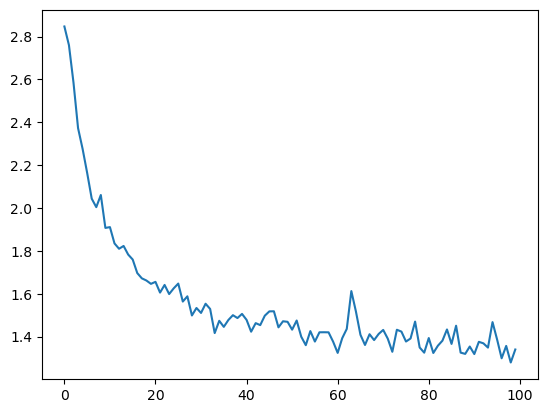

In [15]:
"""
Step 4. Training
"""

def train(category_tensor, line_tensor):
    rnn.zero_grad()
    rnn.hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output = rnn(line_tensor[i])

    loss = criterion(output, category_tensor)
    loss.backward()

    rnn.update_weights(learning_rate)

    return output, loss.item()
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


n_hidden = 128
rnn = MomentumRNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()
learning_rate = 0.005
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(all_losses)
plt.show()

# Task2

## MomentumRNN

In [44]:
"""
Step 3. Creating the Network MomentumRNN
"""
import torch.nn.init as init

class MomentumRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MomentumRNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        # Initialize momentum variables
        self.momentum_i2h = torch.zeros(self.i2h.weight.data.shape)
        self.momentum_i2o = torch.zeros(self.i2o.weight.data.shape)

        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
momentum_rnn = MomentumRNN(n_letters, n_hidden, n_categories)


5000 5% (0m 5s) 0.9307 Groel / German ✓
10000 10% (0m 11s) 0.2297 Hew / Chinese ✓
15000 15% (0m 16s) 0.0054 Pham / Vietnamese ✓
20000 20% (0m 22s) 2.7355 Porcher / Greek ✗ (French)
25000 25% (0m 27s) 0.0276 Koyama / Japanese ✓
30000 30% (0m 33s) 0.0385 Patrianakos / Greek ✓
35000 35% (0m 38s) 0.6963 Parodi / Italian ✓
40000 40% (0m 44s) 0.0695 Ku / Korean ✓
45000 45% (0m 49s) 1.8378 Koci / Japanese ✗ (Czech)
50000 50% (0m 55s) 0.0373 Haddad / Arabic ✓
55000 55% (1m 1s) 0.7843 Allan / Scottish ✓
60000 60% (1m 6s) 2.9663 Aquino / Italian ✗ (Spanish)
65000 65% (1m 12s) 2.1653 Pae / Vietnamese ✗ (Korean)
70000 70% (1m 17s) 0.9791 Mashita / Japanese ✓
75000 75% (1m 23s) 3.1008 Peters / Dutch ✗ (German)
80000 80% (1m 28s) 4.7728 Dovgopoly / Italian ✗ (Russian)
85000 85% (1m 34s) 0.8280 Fugunaga / Japanese ✓
90000 90% (1m 39s) 0.0858 Nomikos / Greek ✓
95000 95% (1m 45s) 0.0023 Mozdzierz / Polish ✓
100000 100% (1m 50s) 0.0887 Melo / Portuguese ✓


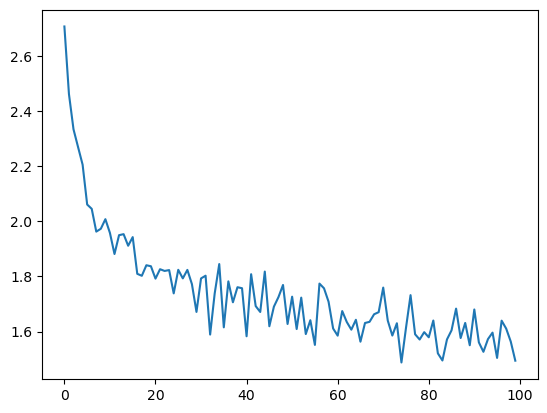

In [45]:
"""
Step 4. Training
"""
# Defining the optimizer with momentum
optimizer = optim.SGD(momentum_rnn.parameters(), lr=learning_rate, momentum=0.9)

# Training loop with momentum optimization
def train_momentum(category_tensor, line_tensor):
    momentum_rnn.zero_grad()

    hidden = momentum_rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = momentum_rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Apply gradient clipping
    torch.nn.utils.clip_grad_norm_(momentum_rnn.parameters(), max_norm=1.0)

    optimizer.step()

    return output, loss.item()

# Training the MomentumRNN
momentum_losses = []
current_loss = 0
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_momentum(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        momentum_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(momentum_losses)


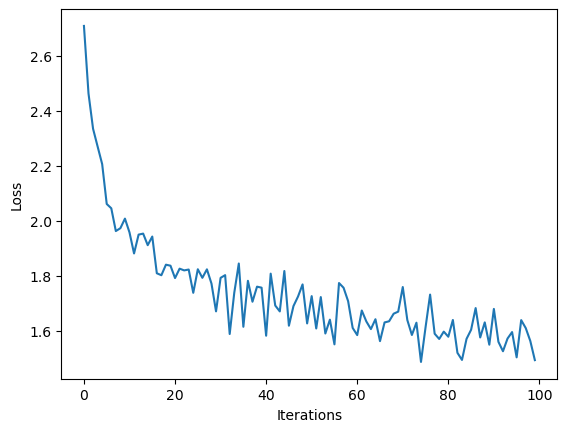

In [91]:
plt.figure()
plt.plot(momentum_losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

/tmp/ipykernel_7642/1035395122.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_7642/1035395122.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


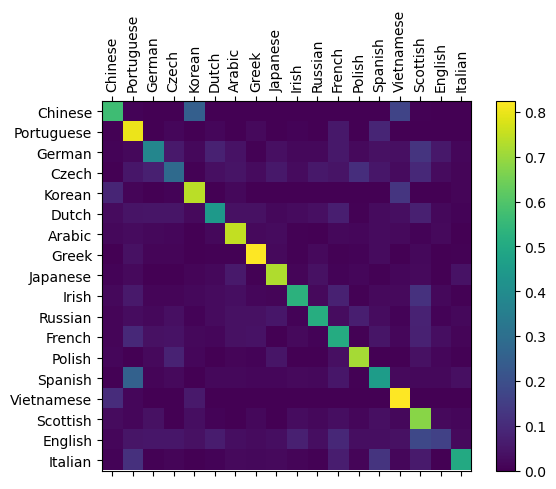

In [48]:
"""
Step 5. Evaluating the results
"""
# Evaluating the network and create a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just returning an output given a line
def evaluate(line_tensor):
    hidden = momentum_rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = momentum_rnn(line_tensor[i], hidden)

    return output

# Going through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalizing by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


In [49]:

"""
Step 5.1: Running on User input
"""
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

# Making predictions for user input
predict('Yuan')
predict('Jackson')
predict('Satoshi')



> Yuan
(-0.50) Korean
(-0.96) Chinese
(-5.75) Vietnamese

> Jackson
(-0.00) Scottish
(-7.44) Russian
(-7.64) English

> Satoshi
(-0.44) Portuguese
(-2.27) Czech
(-3.02) Greek


## RNN

In [50]:
"""
Step 3. Creating the Network RNN
"""
#  Before autograd, creating a recurrent neural network in PyTorch involved cloning
#the parameters of a layer over several timesteps. The layer held hidden state and 
#gradients which are now entirely handled by the graph itself.

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

#  To run a step of this network we need to pass an input (in our case, the Tensor
#for the current letter) and a previous hidden state (which we initialize as zeros
#at first). We'll get back the output (probability of each language) and a next
#hidden state (which we keep for next step).
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

#  As you can see the output is a <1 x n_category> Tensor, where every item is the
#likelihood of that category (higher is more likely).

tensor([[-2.9654, -2.8841, -2.7834, -2.9455, -2.8918, -2.8541, -2.8561, -2.8425,
         -2.8720, -2.8392, -2.8934, -2.8591, -2.9335, -2.9058, -2.9536, -2.8861,
         -2.8801, -3.0051]], grad_fn=<LogSoftmaxBackward0>)


('German', 2)
category = Russian / line = Vaigant
category = Russian / line = Gatturov
category = Portuguese / line = Mateus
category = Spanish / line = De santigo
category = Arabic / line = Almasi
category = Polish / line = Rog
category = Arabic / line = Atiyeh
category = German / line = Leitzke
category = Dutch / line = Seegers
category = Greek / line = Bilias


/tmp/ipykernel_7642/3070653463.py:54: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484746364/work/torch/csrc/utils/python_arg_parser.cpp:1174.)
  p.data.add_(-learning_rate, p.grad.data)


5000 5% (0m 5s) 2.2803 Ferreira / Russian ✗ (Portuguese)
10000 10% (0m 11s) 2.4798 Daele / French ✗ (Dutch)
15000 15% (0m 16s) 0.9745 Shim / Korean ✓
20000 20% (0m 20s) 1.0545 Huan / Chinese ✓
25000 25% (0m 25s) 2.4270 Rosenfeld / French ✗ (German)
30000 30% (0m 29s) 0.5660 Calpis / Greek ✓
35000 35% (0m 33s) 0.8672 Pham / Vietnamese ✓
40000 40% (0m 38s) 0.9881 Anley / English ✓
45000 45% (0m 42s) 0.4237 Dao / Vietnamese ✓
50000 50% (0m 47s) 0.4675 Kouros / Greek ✓
55000 55% (0m 52s) 0.6706 Kau / Chinese ✓
60000 60% (0m 56s) 1.1880 Klerken / Dutch ✓
65000 65% (1m 1s) 0.2765 Gui / Chinese ✓
70000 70% (1m 5s) 1.7344 Marion / Irish ✗ (French)
75000 75% (1m 10s) 1.8593 Abelyan / Scottish ✗ (Russian)
80000 80% (1m 14s) 3.4098 Aarle / Portuguese ✗ (Dutch)
85000 85% (1m 19s) 0.6492 Bermudez / Spanish ✓
90000 90% (1m 24s) 2.4733 Yang / Korean ✗ (Chinese)
95000 95% (1m 31s) 0.3694 Ku / Korean ✓
100000 100% (1m 36s) 0.7327 Pho / Vietnamese ✓


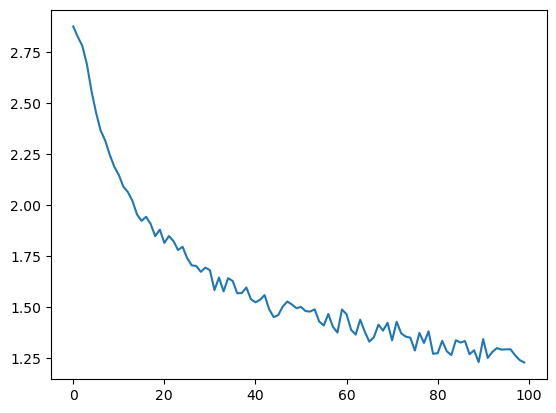

In [51]:
"""
Step 4. Training RNN
"""

#  Before going into training we should make a few helper functions. The first is
#to interpret the output of the network, which we know to be a likelihood of each
#category. We can use Tensor.topk to get the index of the greatest value.
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))


#  We will also want a quick way to get a training example (a name and its language):
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

#  Now all it takes to train this network is show it a bunch of examples, have it
#make guesses, and tell it if it's wrong.
#  For the loss, nn.NLLLoss is appropriate since the last layer of the RNN is 
#nn.LogSoftmax.
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


#  Now we just have to run with a bunch of examples. Since the train function returns
#both the output and loss we can print its guesses and also keep track of loss for
#plotting. Since there are 1000s of examples we print only every print_every examples,
#and take an average of the loss.
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Adding current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


#  Plotting the historical loss from all_losses shows the network learning:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


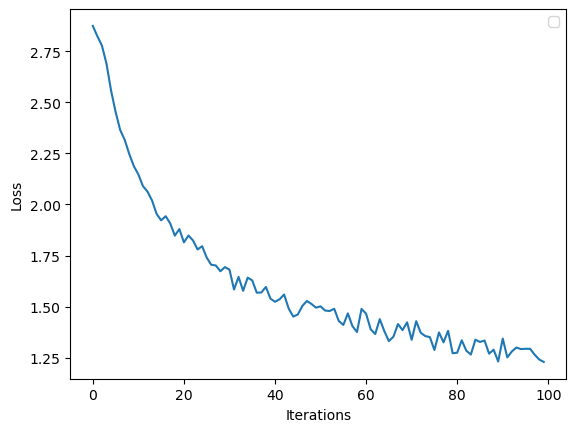

In [90]:
plt.figure()
plt.plot(all_losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

/tmp/ipykernel_7642/2731588864.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_7642/2731588864.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


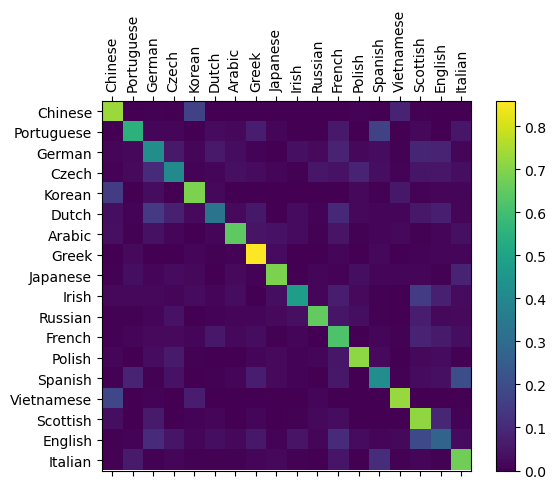

In [52]:
"""
Step 5. Evaluating the results RNN
"""

#  To see how well the network performs on different categories, we will create a confusion
#matrix, indicating for every actual language (rows) which language the network guesses
#(columns). To calculate the confusion matrix a bunch of samples are run through the
#network with evaluate(), which is the same as train() minus the backprop.
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalizing by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Seting up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Seting up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [53]:

"""
Step 5.1: Running on User input
"""
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Geting top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Yuan')
predict('Jackson')
predict('Satoshi')


> Yuan
(-0.36) Chinese
(-1.54) Korean
(-4.00) English

> Jackson
(-0.17) Scottish
(-2.22) English
(-4.06) Greek

> Satoshi
(-1.11) Italian
(-1.34) Japanese
(-2.08) Arabic


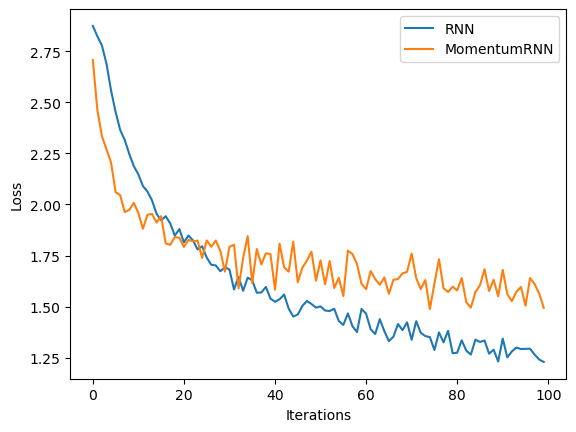

In [89]:
plt.figure()
plt.plot(all_losses, label='RNN')
plt.plot(momentum_losses, label='MomentumRNN')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [59]:
# Evaluating the performance of RNN and MomentumRNN
def evaluate_performance(model):
    # Initializing confusion matrix
    confusion = torch.zeros(n_categories, n_categories)

    # Going through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output = evaluate(line_tensor)  # Corrected line
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return confusion

# Evaluating performance of RNN
rnn_confusion = evaluate_performance(rnn)

# Evaluating performance of MomentumRNN
momentum_rnn_confusion = evaluate_performance(momentum_rnn)

# Print the confusion matrices
print("Confusion Matrix for RNN:")
print(rnn_confusion.numpy())

print("Confusion Matrix for MomentumRNN:")
print(momentum_rnn_confusion.numpy())


Confusion Matrix for RNN:
[[0.77504724 0.         0.01134215 0.         0.13610587 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.06994329 0.00756144 0.         0.        ]
 [0.         0.5711538  0.025      0.01153846 0.         0.01346154
  0.02307692 0.06923077 0.01346154 0.         0.         0.05192308
  0.         0.13846155 0.         0.01538462 0.         0.0673077 ]
 [0.01333333 0.00952381 0.4857143  0.04761905 0.01904762 0.07809523
  0.01714286 0.01142857 0.00190476 0.02285714 0.02095238 0.06857143
  0.00761905 0.00952381 0.01142857 0.0952381  0.07047619 0.00952381]
 [0.02737226 0.01459854 0.09124088 0.35036495 0.01824817 0.01824817
  0.0109489  0.02372263 0.02007299 0.         0.03832117 0.05109489
  0.12956205 0.03832117 0.00364964 0.07664233 0.05291971 0.03467153]
 [0.14285715 0.         0.01964286 0.         0.7107143  0.01428571
  0.         0.         0.         0.         0.         0.
  0.01785714 0.01428571 0.04464286 0.00892

In [60]:
# Calculating accuracy from confusion matrix
def calculate_accuracy(confusion_matrix):
    correct = 0
    total = confusion_matrix.sum()
    for i in range(n_categories):
        correct += confusion_matrix[i][i]
    accuracy = correct / total
    return accuracy

# Calculating accuracy for RNN
rnn_accuracy = calculate_accuracy(rnn_confusion)

# Calculating accuracy for MomentumRNN
momentum_rnn_accuracy = calculate_accuracy(momentum_rnn_confusion)

# Print the accuracies
print("Accuracy for RNN: {:.2%}".format(rnn_accuracy))
print("Accuracy for MomentumRNN: {:.2%}".format(momentum_rnn_accuracy))


Accuracy for RNN: 59.35%
Accuracy for MomentumRNN: 59.29%


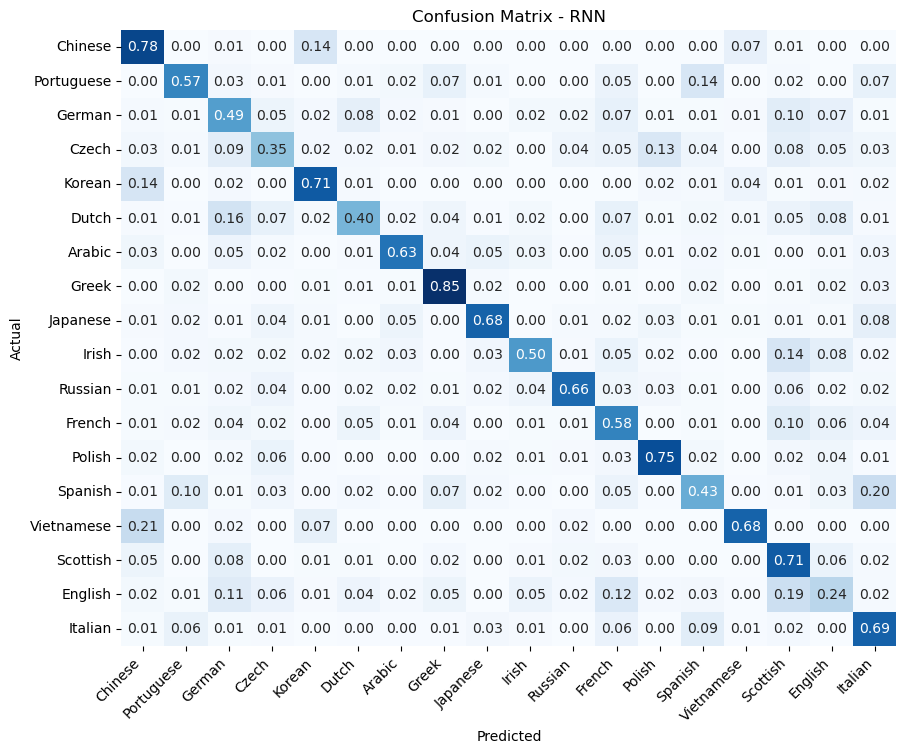

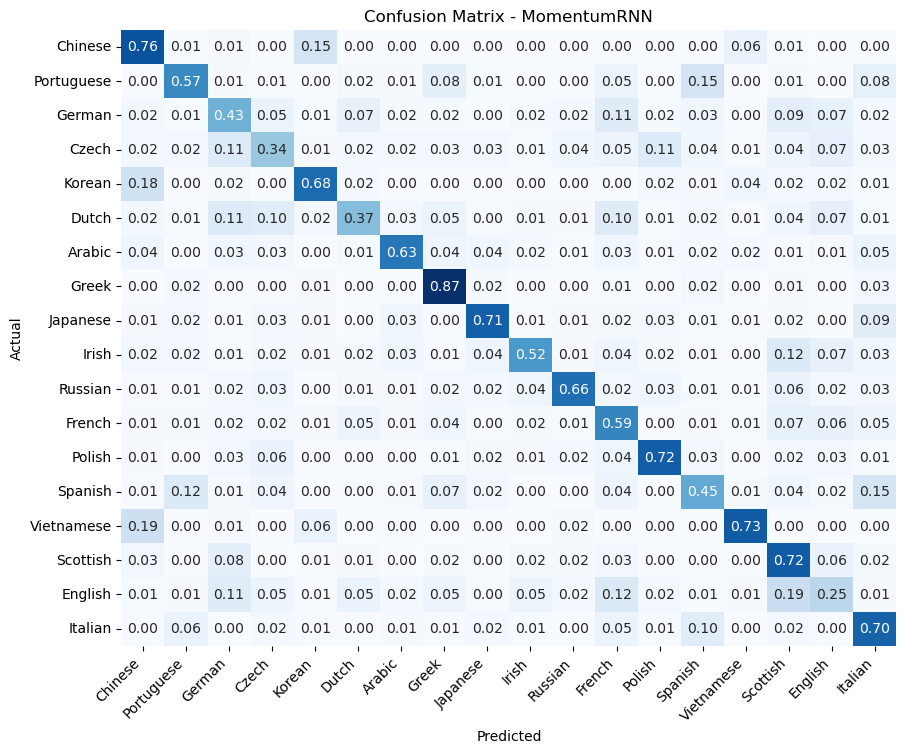

Recalls for RNN:
Chinese: 77.50%
Portuguese: 57.12%
German: 48.57%
Czech: 35.04%
Korean: 71.07%
Dutch: 39.75%
Arabic: 62.67%
Greek: 84.72%
Japanese: 68.35%
Irish: 50.27%
Russian: 65.68%
French: 57.69%
Polish: 75.04%
Spanish: 43.19%
Vietnamese: 68.11%
Scottish: 70.53%
English: 24.39%
Italian: 68.56%

Recalls for MomentumRNN:
Chinese: 75.64%
Portuguese: 56.91%
German: 42.54%
Czech: 33.77%
Korean: 67.57%
Dutch: 37.40%
Arabic: 62.92%
Greek: 87.04%
Japanese: 70.86%
Irish: 51.76%
Russian: 65.93%
French: 58.52%
Polish: 71.82%
Spanish: 45.44%
Vietnamese: 72.61%
Scottish: 72.22%
English: 24.51%
Italian: 69.71%


In [61]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Defining a function to draw the confusion matrix
def draw_confusion_matrix(confusion_matrix, model_name):
    # Normalizing the confusion matrix
    confusion_matrix_normalized = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 8))

    # Using seaborn to plot the confusion matrix heatmap
    sns.heatmap(confusion_matrix_normalized.numpy(), annot=True, fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=all_categories, yticklabels=all_categories, ax=ax)

    # Setting the axis labels and title
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix - " + model_name)

    # Rotating the x-axis labels for better visibility
    plt.xticks(rotation=45, ha="right")

    # Show the plot
    plt.show()

# Drawing confusion matrix for RNN
draw_confusion_matrix(rnn_confusion, "RNN")

# Drawing confusion matrix for MomentumRNN
draw_confusion_matrix(momentum_rnn_confusion, "MomentumRNN")

# Calculating recall for each category
def calculate_recall(confusion_matrix):
    recalls = []
    for i in range(n_categories):
        recall = confusion_matrix[i][i] / confusion_matrix[i].sum()
        recalls.append(recall)
    return recalls

# Calculating recall for RNN
rnn_recalls = calculate_recall(rnn_confusion)

# Calculating recall for MomentumRNN
momentum_rnn_recalls = calculate_recall(momentum_rnn_confusion)

# Print the recalls
print("Recalls for RNN:")
for i, recall in enumerate(rnn_recalls):
    print("{}: {:.2%}".format(all_categories[i], recall))

print("\nRecalls for MomentumRNN:")
for i, recall in enumerate(momentum_rnn_recalls):
    print("{}: {:.2%}".format(all_categories[i], recall))


In [64]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluation function for RNN
def evaluate_rnn(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Evaluation function for MomentumRNN
def evaluate_momentum_rnn(line_tensor):
    hidden = momentum_rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = momentum_rnn(line_tensor[i], hidden)

    return output

# Lists to store predicted and true labels
predicted_rnn = []
predicted_momentum_rnn = []
true_labels = []
true_labels_momentum = [] 

# Evaluation loop for RNN
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_rnn = evaluate_rnn(line_tensor)
    guess_rnn, _ = categoryFromOutput(output_rnn)
    predicted_rnn.append(guess_rnn)
    true_labels.append(category)

# Evaluation loop for MomentumRNN
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_momentum_rnn = evaluate_momentum_rnn(line_tensor)
    guess_momentum_rnn, _ = categoryFromOutput(output_momentum_rnn)
    predicted_momentum_rnn.append(guess_momentum_rnn)
    true_labels_momentum.append(category)

# Print classification report and accuracy for RNN
print("RNN Performance:")
print(classification_report(true_labels, predicted_rnn))
print("Accuracy:", accuracy_score(true_labels, predicted_rnn))

# Print classification report and accuracy for MomentumRNN
print("MomentumRNN Performance:")
print(classification_report(true_labels_momentum, predicted_momentum_rnn))
print("Accuracy:", accuracy_score(true_labels_momentum, predicted_momentum_rnn))


RNN Performance:
              precision    recall  f1-score   support

      Arabic       0.70      0.59      0.64       591
     Chinese       0.60      0.75      0.67       560
       Czech       0.45      0.37      0.41       541
       Dutch       0.56      0.34      0.42       569
     English       0.31      0.25      0.27       572
      French       0.45      0.60      0.51       551
      German       0.43      0.43      0.43       556
       Greek       0.68      0.86      0.76       551
       Irish       0.72      0.51      0.60       551
     Italian       0.53      0.69      0.60       535
    Japanese       0.77      0.66      0.71       570
      Korean       0.66      0.69      0.68       532
      Polish       0.71      0.74      0.73       530
  Portuguese       0.67      0.59      0.63       565
     Russian       0.78      0.66      0.72       526
    Scottish       0.49      0.72      0.58       590
     Spanish       0.49      0.44      0.46       564
  Vietname

## LSTM

In [65]:
"""
Repeating the above steps with the LSTM model
"""

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size

        self.LSTM = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=False,
        )
        self.linear = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=1)
    def forward(self,x):
        lstm,_ = self.LSTM(x) 
        out = self.linear(lstm[-1, :, :])
        #output =self.softmax(out)
        return out

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)
#criterion = nn.NLLLoss()
criterion=nn.CrossEntropyLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_lstm(category_tensor, line_tensor):
    lstm.zero_grad()

    #for i in range(line_tensor.size()[0]):
    output = lstm(line_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [66]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keeping track of losses for plotting
current_loss = 0
lstm_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Adding current loss avg to list of losses
    if iter % plot_every == 0:
        lstm_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 2.8108 Deniaud / Greek ✗ (French)
10000 10% (0m 20s) 2.6508 Panayiotopoulos / Greek ✓
15000 15% (0m 28s) 2.8855 Romero / Spanish ✗ (Italian)
20000 20% (0m 37s) 2.6752 Evarestov / Greek ✗ (Russian)
25000 25% (0m 46s) 2.1752 Pakulski / Polish ✓
30000 30% (0m 54s) 2.5671 Boer / Vietnamese ✗ (German)
35000 35% (1m 3s) 1.5840 Blades / Greek ✓
40000 40% (1m 11s) 1.4091 To / Korean ✗ (Vietnamese)
45000 45% (1m 20s) 2.0480 Rodrigues / Greek ✗ (Portuguese)
50000 50% (1m 28s) 1.4603 Ton / Chinese ✗ (Vietnamese)
55000 55% (1m 37s) 1.0696 Pasternack / Polish ✓
60000 60% (1m 46s) 1.6585 Pae / Chinese ✗ (Korean)
65000 65% (1m 54s) 2.8078 Broz / Spanish ✗ (Polish)
70000 70% (2m 2s) 0.9550 Janick / Czech ✓
75000 75% (2m 11s) 1.6487 Rossem / Dutch ✓
80000 80% (2m 19s) 2.0873 Watt / German ✗ (Scottish)
85000 85% (2m 27s) 1.0391 Urbanovska / Polish ✗ (Czech)
90000 90% (2m 36s) 2.2270 Lorenz / Spanish ✗ (German)
95000 95% (2m 44s) 1.0241 Suh / Chinese ✗ (Korean)
100000 100% (2m 52s) 2.428

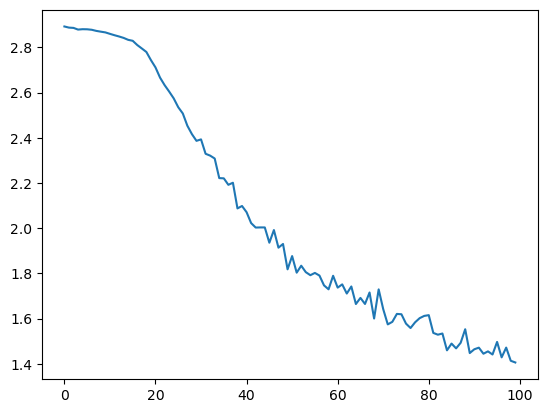

In [67]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(lstm_losses)

In [68]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = lstm(lineToTensor(input_line))

        # Geting top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Yuan')
predict('Jackson')
predict('Satoshi')


> Yuan
(5.02) Chinese
(4.59) Vietnamese
(3.90) Korean

> Jackson
(4.09) Scottish
(3.82) English
(3.23) Russian

> Satoshi
(5.79) Japanese
(5.39) Arabic
(2.90) Polish


/tmp/ipykernel_7642/983831820.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_7642/983831820.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


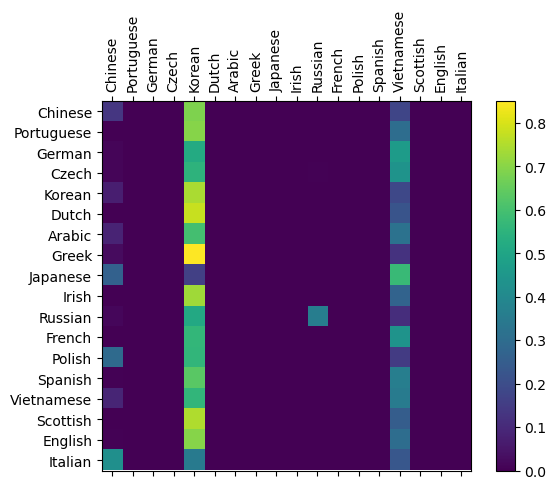

In [83]:
'''
Evaluating the results'''
import matplotlib.ticker as ticker

# Initializing the confusion matrix
confusion_lstm = torch.zeros(n_categories, n_categories)

def evaluate_lstm(line_tensor):
    hidden = None  # Initialize hidden state for LSTM

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i].unsqueeze(0))
        

    return output

n_confusion = 10000  # Defining the number of samples for the confusion matrix

for i in range(n_confusion):
    _, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = category_tensor.item()
    confusion_lstm[category_i][guess_i] += 1

for i in range(n_categories):
    confusion_lstm[i] = confusion_lstm[i] / confusion_lstm[i].sum()

# Plot the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_lstm.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Task3
## MomentumLSTM

In [72]:
"""
Step 3. Creating the Network MomentumLSTM
"""
import torch.nn as nn
import torch.nn.init as init

class MomentumLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MomentumLSTM, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        # Initializing momentum variables
        self.momentum_lstm_ih = torch.zeros_like(self.lstm.weight_ih_l0)
        self.momentum_lstm_hh = torch.zeros_like(self.lstm.weight_hh_l0)
        self.momentum_fc = torch.zeros_like(self.fc.weight)

        # Initializing weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param)

    def forward(self, input, hidden):
        lstm_out, hidden = self.lstm(input, hidden)
        output = self.fc(lstm_out[-1])
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size=1):
        device = next(self.parameters()).device
        return (torch.zeros(1, batch_size, self.hidden_size).to(device),
                torch.zeros(1, batch_size, self.hidden_size).to(device))
    
# Creatting an instance of MomentumLSTM
momentum_lstm = MomentumLSTM(n_letters, n_hidden, n_categories)


5000 5% (0m 16s) 1.7773 Wang / Vietnamese ✗ (Korean)
10000 10% (0m 30s) 3.4025 Kouman / Irish ✗ (Dutch)
15000 15% (0m 45s) 1.0601 Pan / Vietnamese ✗ (Chinese)
20000 20% (0m 59s) 0.6066 Wilson / Scottish ✓
25000 25% (1m 14s) 0.4423 Hua / Chinese ✓
30000 30% (1m 29s) 1.7695 Lieu / Chinese ✗ (Vietnamese)
35000 35% (1m 43s) 4.9968 Kerner / German ✗ (Czech)
40000 40% (1m 57s) 1.3788 Lewerentz / Dutch ✗ (German)
45000 45% (2m 12s) 1.2013 Sitz / German ✓
50000 50% (2m 26s) 1.0725 Cuocco / Portuguese ✗ (Italian)
55000 55% (2m 41s) 2.5667 Castell / Dutch ✗ (Spanish)
60000 60% (2m 55s) 4.5443 Eustis / Greek ✗ (French)
65000 65% (3m 10s) 0.0153 Mcmillan / Scottish ✓
70000 70% (3m 25s) 0.0051 Gorski / Polish ✓
75000 75% (3m 40s) 0.0019 Chepikov / Russian ✓
80000 80% (3m 55s) 0.2267 Grant / Scottish ✓
85000 85% (4m 10s) 0.0012 Shalhoub / Arabic ✓
90000 90% (4m 24s) 1.2587 Campos / Greek ✗ (Portuguese)
95000 95% (4m 39s) 0.0349 Thai / Vietnamese ✓
100000 100% (4m 54s) 0.0507 Kaima / Japanese ✓


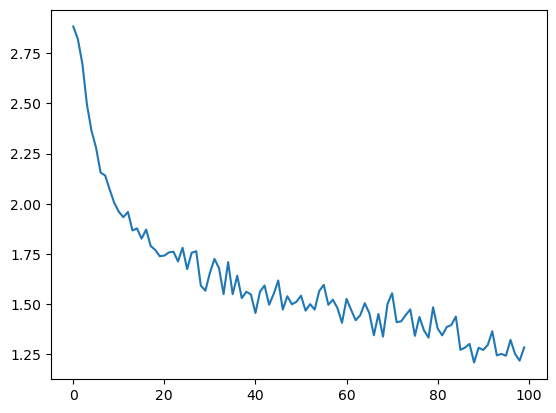

In [73]:
# Define the optimizer with momentum for MomentumLSTM
optimizer_lstm = optim.SGD(momentum_lstm.parameters(), lr=learning_rate, momentum=0.9)

# Training loop with momentum optimization for MomentumLSTM
def train_momentum_lstm(category_tensor, line_tensor):
    momentum_lstm.zero_grad()

    hidden = momentum_lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = momentum_lstm(line_tensor[i].unsqueeze(0), hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Applying gradient clipping
    torch.nn.utils.clip_grad_norm_(momentum_lstm.parameters(), max_norm=1.0)

    optimizer_lstm.step()

    return output, loss.item()

# Training the MomentumLSTM
momentum_lstm_losses = []
current_loss = 0
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_momentum_lstm(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        momentum_lstm_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(momentum_lstm_losses)


In [78]:
def predict_momentum_lstm(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        input_tensor = lineToTensor(input_line)
        input_tensor = input_tensor.unsqueeze(0)  # Adding batch dimension
        hidden = momentum_lstm.initHidden()

        for i in range(input_tensor.size()[1]):
            output, hidden = momentum_lstm(input_tensor[:, i], hidden)

        # Getting top N categories
        topv, topi = output.topk(n_predictions, dim=1)  # Updated indexing
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()  # Updated indexing
            category_index = topi[0][i].item()  # Updated indexing
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict_momentum_lstm('Yuan')
predict_momentum_lstm('Jackson')
predict_momentum_lstm('Satoshi')



> Yuan
(-0.00) Chinese
(-6.31) Korean
(-8.15) Vietnamese

> Jackson
(-0.01) Scottish
(-5.02) English
(-7.62) Russian

> Satoshi
(-0.31) Japanese
(-1.61) Arabic
(-2.86) Italian


/tmp/ipykernel_7642/282279378.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_7642/282279378.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


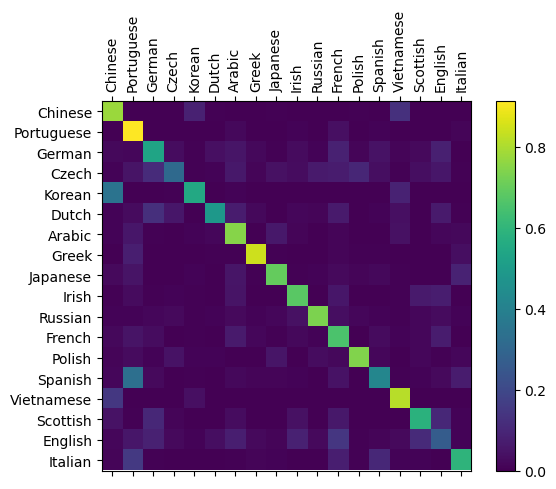

In [80]:
# Evaluating the network and create a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = momentum_lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = momentum_lstm(line_tensor[i].unsqueeze(0), hidden)

    return output

# Going through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalizing by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Setting up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Setting up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


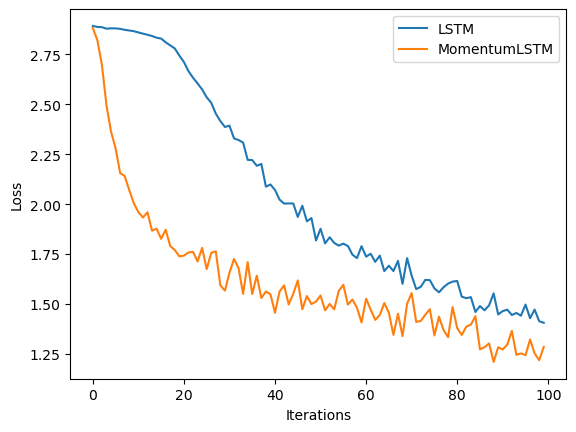

In [88]:

plt.figure()
plt.plot(lstm_losses, label='LSTM')
plt.plot(momentum_lstm_losses, label='MomentumLSTM')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [84]:
# Lists to store predicted and true labels for LSTM
predicted_lstm = []
true_labels_lstm = []

# Lists to store predicted and true labels for MomentumLSTM
predicted_momentum_lstm = []
true_labels_momentum_lstm = []

# Evaluation loop for LSTM
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_lstm = evaluate_lstm(line_tensor)
    guess_lstm, _ = categoryFromOutput(output_lstm)
    predicted_lstm.append(guess_lstm)
    true_labels_lstm.append(category)

# Evaluation loop for MomentumLSTM
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_momentum_lstm = evaluate_momentum_lstm(line_tensor)
    guess_momentum_lstm, _ = categoryFromOutput(output_momentum_lstm)
    predicted_momentum_lstm.append(guess_momentum_lstm)
    true_labels_momentum_lstm.append(category)

# Print classification report and accuracy for LSTM
print("LSTM Performance:")
print(classification_report(true_labels_lstm, predicted_lstm))
print("Accuracy:", accuracy_score(true_labels_lstm, predicted_lstm))

# Print classification report and accuracy for MomentumLSTM
print("MomentumLSTM Performance:")
print(classification_report(true_labels_momentum_lstm, predicted_momentum_lstm))
print("Accuracy:", accuracy_score(true_labels_momentum_lstm, predicted_momentum_lstm))


LSTM Performance:
              precision    recall  f1-score   support

      Arabic       0.00      0.00      0.00       545
     Chinese       0.09      0.14      0.11       535
       Czech       0.00      0.00      0.00       525
       Dutch       0.00      0.00      0.00       546
     English       0.00      0.00      0.00       532
      French       0.00      0.00      0.00       556
      German       0.00      0.00      0.00       580
       Greek       0.00      0.00      0.00       554
       Irish       0.00      0.00      0.00       578
     Italian       0.00      0.00      0.00       587
    Japanese       0.00      0.00      0.00       587
      Korean       0.06      0.70      0.11       529
      Polish       0.00      0.00      0.00       579
  Portuguese       0.00      0.00      0.00       557
     Russian       0.99      0.36      0.53       554
    Scottish       0.00      0.00      0.00       603
     Spanish       0.00      0.00      0.00       490
  Vietnam

/home/song/anaconda3/envs/Action/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/song/anaconda3/envs/Action/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/song/anaconda3/envs/Action/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

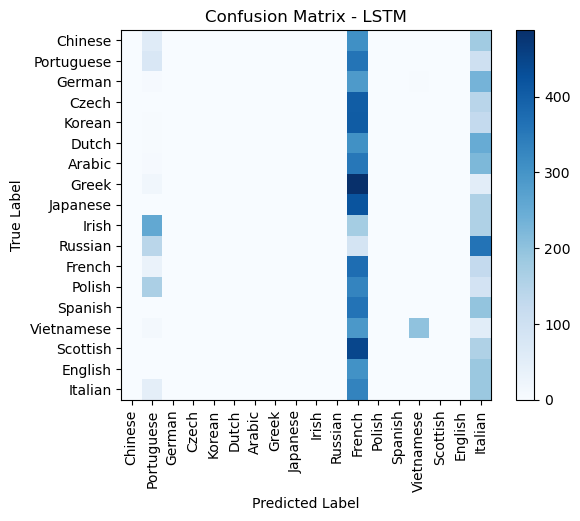

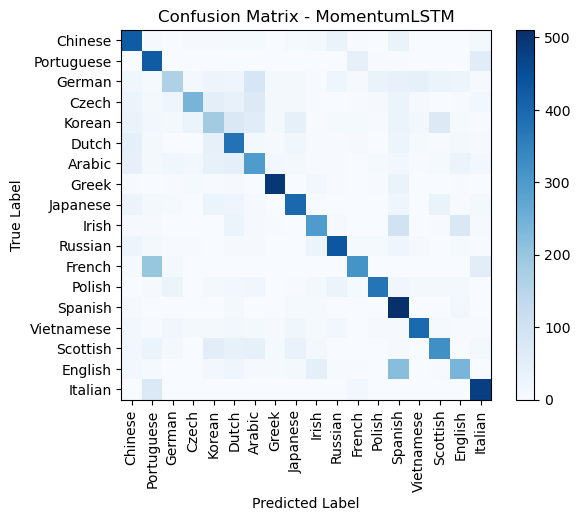

In [85]:
from sklearn.metrics import confusion_matrix

# Evaluating LSTM model and create a confusion matrix
lstm_confusion = confusion_matrix(true_labels_lstm, predicted_lstm)

# Evaluating MomentumLSTM model and create a confusion matrix
momentum_lstm_confusion = confusion_matrix(true_labels_momentum_lstm, predicted_momentum_lstm)

# Ploting the LSTM confusion matrix
plt.figure()
plt.imshow(lstm_confusion, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xticks(range(n_categories), all_categories, rotation=90)
plt.yticks(range(n_categories), all_categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM')

# Ploting the MomentumLSTM confusion matrix
plt.figure()
plt.imshow(momentum_lstm_confusion, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xticks(range(n_categories), all_categories, rotation=90)
plt.yticks(range(n_categories), all_categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - MomentumLSTM')

plt.show()


## revised LSTM to improve the accuracy

In [92]:
import torch
import torch.nn as nn
import string
import random

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.fc(output[-1])  # Use the last output sequence
        return output

# Prepare the data
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Define categories and names
categories = ['English', 'French', 'Spanish']
names = {
    'English': ['Smith', 'Johnson', 'Brown'],
    'French': ['Dupont', 'Leblanc', 'Lefebvre'],
    'Spanish': ['Garcia', 'Lopez', 'Rodriguez']
}

# Convert names to tensors
category_lines = {}
for category, name_list in names.items():
    lines = [lineToTensor(name) for name in name_list]
    category_lines[category] = lines

# Define the LSTM model and criterion
hidden_size = 128
output_size = len(categories)
lstm = LSTM(n_letters, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()

# Training
learning_rate = 0.005
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

def lineToTensor(line):
    tensor = torch.zeros(len(line), n_letters)
    for li, letter in enumerate(line):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

def letterToIndex(letter):
    return all_letters.find(letter)


def line_tensorToName(line_tensor):
    name = ""
    for tensor in line_tensor:
        _, idx = tensor.max(dim=1)  # Fix the dimension for finding the max value
        letter = all_letters[idx.item()]
        name += letter
    return name

# Within the train function
def train(category_tensor, line_tensor):
    hidden = torch.zeros(1, 1, hidden_size)
    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i].unsqueeze(0))
        hidden = output

    # Modify the category_tensor shape
    category_tensor = category_tensor.squeeze()

    loss = criterion(output.squeeze(), category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()



n_iters = 10000
print_every = 500
plot_every = 100
current_loss = 0

for iter in range(1, n_iters + 1):
    category = random.choice(categories)
    line_tensor = random.choice(category_lines[category])
    category_tensor = torch.tensor([categories.index(category)], dtype=torch.long)

    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess = categories[torch.argmax(output)]
        correct = '✓' if guess == category else '✗'
        print(f'{iter} {iter / n_iters * 100}% Loss: {loss:.4f} Name: {line_tensorToName(line_tensor)} Guess: {guess} {correct}')

    if iter % plot_every == 0:
        current_loss /= plot_every
        # TODO: Plot the loss

# Prediction
def predict(input_line):
    with torch.no_grad():
        input_tensor = lineToTensor(input_line)
        output = lstm(input_tensor)
        top_category = categories[torch.argmax(output)]
        return top_category

# Example prediction
input_name = "Gomez"
predicted_category = predict(input_name)
print(f"Input: {input_name}, Predicted Category: {predicted_category}")


500 5.0% Loss: 1.0709 Name: Brown Guess: English ✓
1000 10.0% Loss: 1.0790 Name: Garcia Guess: Spanish ✓
1500 15.0% Loss: 1.0281 Name: Smith Guess: English ✓
2000 20.0% Loss: 1.0228 Name: Garcia Guess: Spanish ✓
2500 25.0% Loss: 1.0002 Name: Smith Guess: English ✓
3000 30.0% Loss: 1.0488 Name: Rodriguez Guess: Spanish ✓
3500 35.0% Loss: 0.9778 Name: Smith Guess: English ✓
4000 40.0% Loss: 0.8840 Name: Leblanc Guess: French ✓
4500 45.0% Loss: 0.7928 Name: Lopez Guess: Spanish ✓
5000 50.0% Loss: 0.6791 Name: Brown Guess: English ✓
5500 55.00000000000001% Loss: 0.6505 Name: Johnson Guess: English ✓
6000 60.0% Loss: 0.7605 Name: Lefebvre Guess: French ✓
6500 65.0% Loss: 0.4787 Name: Brown Guess: English ✓
7000 70.0% Loss: 0.4123 Name: Brown Guess: English ✓
7500 75.0% Loss: 0.5334 Name: Lefebvre Guess: French ✓
8000 80.0% Loss: 0.2286 Name: Rodriguez Guess: Spanish ✓
8500 85.0% Loss: 0.1870 Name: Rodriguez Guess: Spanish ✓
9000 90.0% Loss: 0.3162 Name: Lefebvre Guess: French ✓
9500 95.0% L

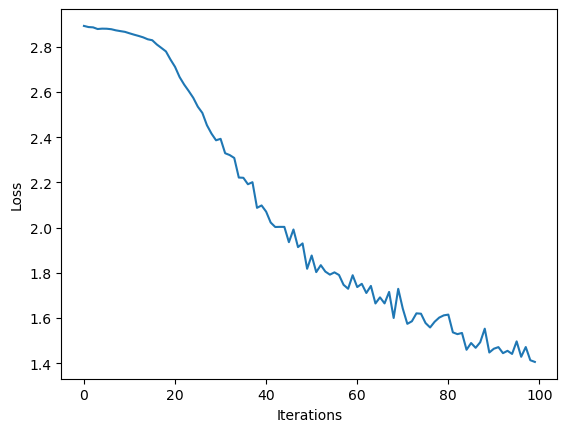

In [93]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(lstm_losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [94]:

def predict(input_line):
    with torch.no_grad():
        input_tensor = lineToTensor(input_line)
        output = lstm(input_tensor)
        top_category = categories[torch.argmax(output)]
        return top_category

# Example prediction
input_name = "Gomez"
predicted_category = predict(input_name)
print(f"Input: {input_name}, Predicted Category: {predicted_category}")
# predict('Yuan')
# predict('Jackson')
# predict('Satoshi')

Input: Gomez, Predicted Category: Spanish


In [95]:
# Create empty lists to store predictions and actual categories
all_predictions = []
all_actuals = []

# Within the training loop
if iter % print_every == 0:
    guess = categories[torch.argmax(output)]
    correct = '✓' if guess == category else '✗'
    all_predictions.append(guess)
    all_actuals.append(category)

# After the training loop
# Convert the prediction and actual lists to tensors
prediction_tensor = torch.tensor([categories.index(p) for p in all_predictions], dtype=torch.long)
actual_tensor = torch.tensor([categories.index(a) for a in all_actuals], dtype=torch.long)


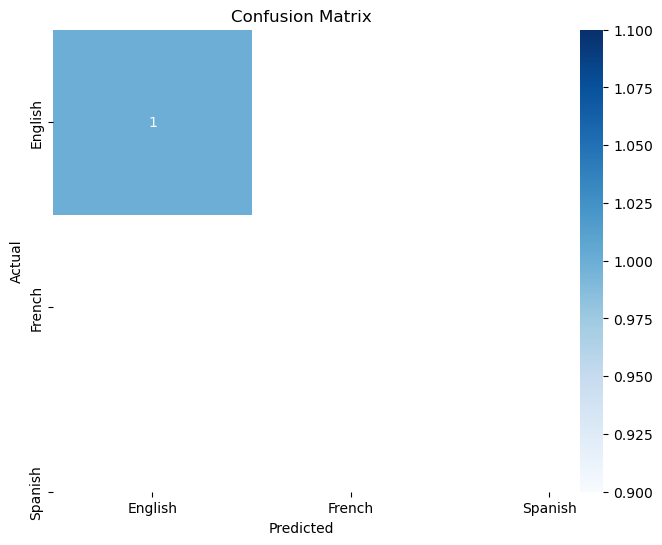

In [97]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(actual_tensor.numpy(), prediction_tensor.numpy())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [98]:
# Calculate the accuracy
correct_count = (prediction_tensor == actual_tensor).sum().item()
total_count = len(all_predictions)
accuracy = correct_count / total_count * 100

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 100.00%
